# EDU simulations

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

def age_distribution (a, Tc):
    # Age distribution of cells given the 
    # cell cycle lenght Tc and an exponential growth
    return (2*math.log(2)/Tc)*math.exp(-math.log(2)*a/Tc)

In [2]:
def sample_age(Tc):
    # Sample random age from ages distribution
    # Accept-Reject method
    accepted = False
    while not accepted:
        # sample uniformly one age from 0 to Tc
        u = np.random.uniform(low = 0., high = Tc)
        # sample uniformly from min to max
        # values of the ages distribution
        v = np.random.uniform(low = 0., high = math.log(4)/Tc + 0.01)
        # accept or reject
        if v <= age_distribution(u, Tc):
            accepted = True
    # return accepted age
    return u;

## EDU simulations - deterministic model
Every cell has the same times for the cell cycle's phases and the stochasticity is given by the sampling from the age distribution.

Fixed time parameters for the cell cycle are:
 - $T_C$, total cell cycle time
 - $T_{G_1}$
 - $T_S$
 - $T_{G_2+M}$

but just three of the four parameters are independent: $T_C = T_{G_1} + T_S + T_{G_2+M}$.

In simulation we can rescale all cycle times by the total cycle time $T_C$ so that we have three independent parameters:
   
   - $\frac{T_{G_1}}{T_C}$
   - $\frac{T_S}{T_C} $
   - $\frac{T_{G_2 + M}}{T_C}$

the sum of which is equal to 1. 

We can use times found in literature. 
For example taking data from https://bionumbers.hms.harvard.edu/bionumber.aspx?s=n&v=3&id=112260 we have:

_"The duration of these cell cycle phases varies considerably in different kinds of cells. For a typical rapidly proliferating human cell with a total cycle time of 24 hours, the G1 phase might last about 11 hours, S phase about 8 hours, G2 about 4 hours, and M about 1 hour."_

So we can take the three independent parameters as follows.

   - $\frac{T_{G_1}}{T_C} = \frac{11}{24}$
   - $\frac{T_S}{T_C} = \frac{8}{24}$
   - $\frac{T_{G_2 + M}}{T_C}= \frac{5}{24}$
   
**Simulation algorithm:**

1. We create a population of N cells: for each cell its age is sampled from ages' distribution with accept-reject method.

2. Based on the cell's age we define its current phase.

3. For times in [0, 1.3 * $T_c$] we compute the total number of cell that are or were in the S-phase and count them as $\text{EDU}^+ $ and we save the couple of values (t, %$\text{EDU}^+ $)

4. If the age of a cell reaches the total lenght of the cycle at time $t$ from the start of the experiment it means that that cell has produced two daughters. We increase the total number of cells in the population by one: daughter cells will have age of $(t-T_C)$ and will be counted as $\text{EDU}^+ $ only if the mother cell was marked (was preaviously in the S-phase)

5. Reached the time limit $t = 1.3 \cdot T_c$, we plot the graph of saved couples (t, %$\text{EDU}^+ $)

In [3]:
class Cell :
    
    def __init__(self, 
                 age = None, labelled = False, 
                Tc = 1, TG1 = 11./24, TS = 8./24, TG2M = 5./24):
        
        # Individual phases' times
        self._TG1 = TG1 # G1
        self._TS = TS # S
        self._TG2M = TG2M # G2 + M
        self._Tc = Tc # Total cell cycle time
        
        assert Tc == TG1 + TS + TG2M
        
        # Age
        self._age = age
        
        # EDU label
        self._labelled = labelled 
    
    def get_copy_number(self):
        # if cell is in G1 return 1
        if self._age <= self._TG1 :
            return 1.
        # if cell is S linearly interpolate from 1 and 2
        if (self._age > self._TG1) & (self._age <= self._TG1 + self._TS):
            copy_number = (2. - 1.)/self._TS
            copy_number *= (self._age - self._TG1)
            copy_number += 1
            assert (copy_number > 1.) & (copy_number < 2.)
            return copy_number
        # if cell is in G2 or M return 2
        if self._age > self._TG1 + self._TS:
            return 2.

In [4]:
class EDU_deterministic_experiment :
    
    def __init__(self, N_cells = 1000, T_tot = 1.3, 
                 Tc = 1., TG1 = 11./24, TS = 8./24, TG2M = 5./24):
        
        # Initial number of cells
        self._N_cells = N_cells
        self._initial_N_cells = N_cells
        
        # Total time of the experiment
        self._T_tot = T_tot
        
        # Individual phases' times
        self._TG1 = TG1 # G1
        self._TS = TS # S
        self._TG2M = TG2M # G2 + M
        self._Tc = Tc # Total cell cycle time
        
        assert Tc == TG1 + TS + TG2M
        
        # The population is a list of cells
        self._population = []
        # generate initial population
        for _ in range(self._N_cells):
            # Sample age from ages' distribution given Tc
            age = self.sample_age(self._Tc)
            # Add a cell with that age that is unlabelled
            # In this deterministic version of the simulation
            # we have fixed phases' times
            self._population.append(
                Cell(age = age, labelled = False,
                     TG1 = self._TG1, TS = self._TS, 
                     TG2M = self._TG2M, Tc = self._Tc)
            )
            
        # Results are couples (t, %EDU-positive)
        self._times = []
        self._positive_fraction = []
        
        # We also save data for copy-number histogram
        self._copy_number = []
        for cell in self._population :
            self._copy_number.append(cell.get_copy_number())
            assert (self._copy_number[-1] >= 1. ) & (self._copy_number[-1] <= 2. ) 
        
    def sample_age(self, Tc):
        # Sample random age from ages distribution
        # Accept-Reject method
        accepted = False
        while not accepted:
            # sample uniformly one age from 0 to Tc
            u = np.random.uniform(low = 0., high = Tc)
            # sample uniformly from min to max
            # values of the ages distribution
            v = np.random.uniform(low = 0., high = math.log(4)/Tc + 0.01)
            # accept or reject
            if v <= self.age_distribution(u, Tc):
                accepted = True
        # return accepted age
        return u;
    
    def age_distribution(self, a, Tc):
        # Age distribution of cells given the 
        # cell cycle lenght Tc
        return (2*math.log(2)/Tc)*math.exp(-math.log(2)*a/Tc)
    
    def run_experiment(self, N_timesteps = 100):
        
        # Times at which positive cells cout is performed
        self._times = np.linspace(0., self._T_tot, num = N_timesteps)
        
        delta_t = self._times[1]
        
        # For all measurement's times
        for t in self._times:
           
            new_born = 0  # New born cells counter
            new_ages = [] # ages of new cells
            new_labelled = [] # label-status of new cells
            
            # For all cells
            for cell in self._population:
                # add delta_t to cell age
                cell._age += delta_t
                # if cell is in the S phase
                if (cell._age >= cell._TG1 ) & (cell._age <= cell._TG1 + cell._TS) :
                    # mark the cell as labelled 
                    cell._labelled = True
                    
                # if the cell completed the cycle
                if cell._age > cell._Tc:
                    # the cell divide and two new cell are made
                    # total number of cell increases by one
                    self._N_cells += 1
                    
                    # daughters will be labelled if the progenitor were labelled
                    labelled = cell._labelled 
                    
                    # the age of the new cells is the difference 
                    # between (age + t) and Tc
                    age = cell._age - cell._Tc
                    
                    # Two new cells in population are the old cell
                    # with age set to the new one and another new cell
                    
                    cell._age = age 
                    # label is the same as before 
                    
                    # we need to add a cell to population list
                    # but we can't do that during this iteration 
                    # (on population list).
                    # So we have to save total number of new born cells 
                    # to add later and their age and label-status
                    new_born += 1
                    new_ages.append(age)
                    new_labelled.append(labelled)
            
            # We add new cells to the population list
            #for every new cell
            for i in range(new_born):
                # we add a cell with that age and label-status
                # in this deterministic version phases' times are fixed
                self._population.append(
                    Cell(age = new_ages[i], labelled = new_labelled[i], 
                         TG1 = self._TG1, TS = self._TS, 
                         TG2M = self._TG2M, Tc = self._Tc)
                )
            
            #We then perform EDU-positive cell count 
            EDU_positive = 0
            
            for cell in self._population :
                if cell._labelled :
                    EDU_positive += 1
            
            # calculate EDU-positive fraction of cells
            positive_fraction = float(EDU_positive)/float(self._N_cells)
            # save result
            self._positive_fraction.append(positive_fraction)
            
    def plot_EDU(self):
        plt.plot(self._times, self._positive_fraction, label = "simualtion")
        plt.title("Deterministic EDU experiment\n"+str(self._initial_N_cells)+" initial cells")
        plt.ylabel(r"Fraction of EDU${}^+$ cells")
        plt.xlabel("Time (units of Tc)")
        
        # plot analytic estimation form explicit cell cicle
        # Eq. 8 from "EDU_labelling_dynamics"
        f = []
        for t in self._times:
            if t < self._TG2M : # t < T_G2M
                f.append(math.pow(2., (self._TG2M + self._TS)/self._Tc) 
                         - math.pow(2., (self._TG2M - t)/self._Tc)
                        )
            else: # t > T_G2M
                if t < (self._Tc - self._TS) : # T_G2M <= t < (T_c - T_S)
                    f.append(1. - (math.pow(2., (self._TG2M + self._Tc - t)/self._Tc)
                                  - math.pow(2., (self._TG2M + self._TS)/self._Tc)
                                  )
                            )
                else: # t >= (T_c - T_S)
                    f.append(1.)
        
        plt.plot(self._times, f, label = "analytic")
        
    def plot_copy_number(self, bins = 30, save = None):
        fig = plt.figure(figsize=(14,14))
        ax = fig.add_subplot(1, 1, 1)
        ax.hist(self._copy_number, bins = bins, label = "Simulazione")

        ax.set_xlabel("Copy number", fontsize=40)
        ax.set_ylabel("Conteggi", fontsize=40)
        ax.yaxis.offsetText.set_fontsize(40)
        ## set ticks
        ax.tick_params(which='major', width=2.0, labelsize=40)
        ax.tick_params(which='major', length=20, labelsize=40)
        ax.legend(fontsize=40, title='Legenda',title_fontsize=40)
        plt.tight_layout()
        if save != None:
            plt.savefig(save)
        plt.show()
    
    def plot_age_distribution(self, bins = 30, save = None):
        fig = plt.figure(figsize=(14,14))
        ax = fig.add_subplot(1, 1, 1)
        # plot ages istogram
        cell_ages = [cell._age for cell in self._population]
        ax.hist(cell_ages, bins = bins, label = "Simulazione")
        # plot age distribution n(a)
        ages = np.linspace(0,self._Tc)
        area = self._N_cells*self._Tc/bins
        distribution = [area*self.age_distribution(a,self._Tc) for a in ages]
        ax.plot(ages, distribution, color ="red",lw = 6, label = "Distribuzione età")
        ax.set_xlabel(r"Età (unità di $T_c$)", fontsize=40)
        ax.set_ylabel("Conteggi", fontsize=40)
        ax.yaxis.offsetText.set_fontsize(40)
        ## set ticks
        ax.tick_params(which='major', width=2.0, labelsize=40)
        ax.tick_params(which='major', length=20, labelsize=40)
        ax.legend(fontsize=40, title='Legenda',title_fontsize=40)
        plt.tight_layout()
        if save != None:
            plt.savefig(save)
        plt.show()

Figure A1, section A.1.

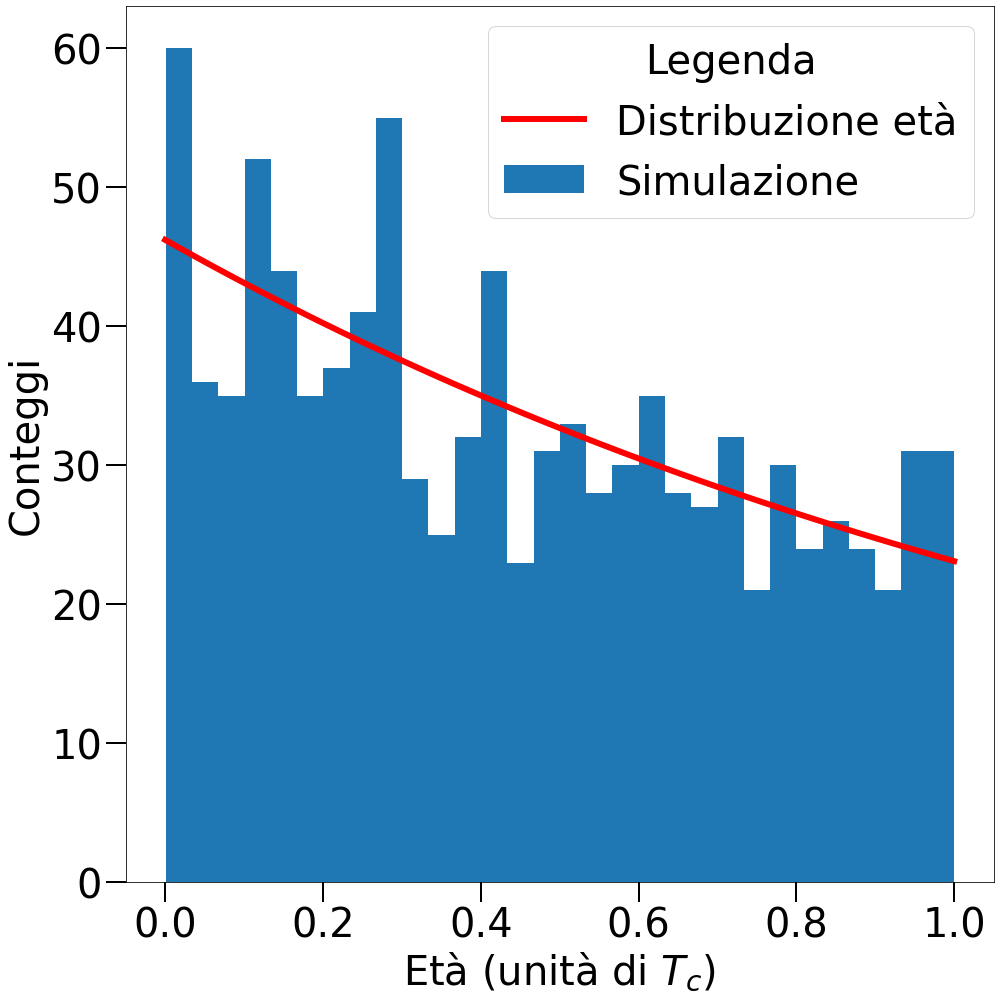

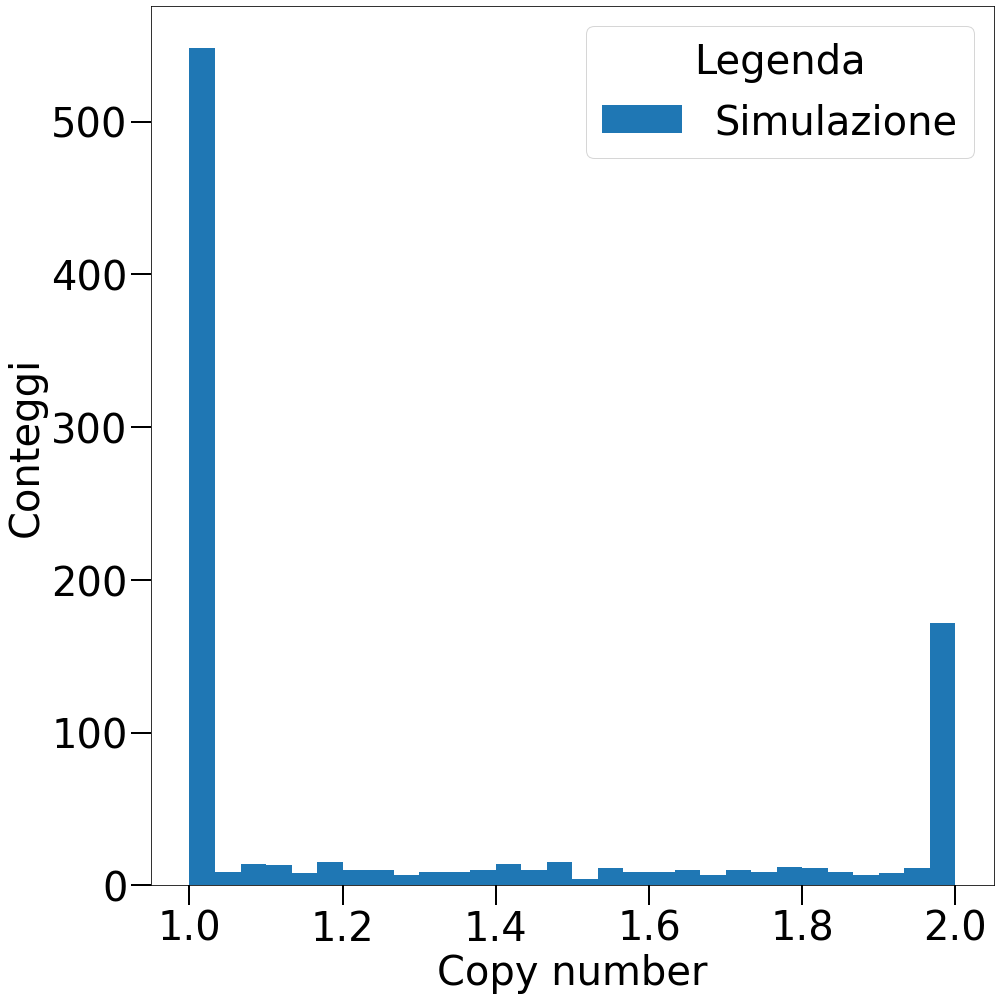

In [5]:
np.random.seed(0)
exp = EDU_deterministic_experiment(T_tot = 1., N_cells = 1000, 
                                   Tc = 1., TG1 = 11./24, TS = 8./24, TG2M = 5./24)
exp.plot_age_distribution()

exp.plot_copy_number()
exp.run_experiment(N_timesteps = 100)

## EDU simulations - stochastic model (Gaussian times)

Every cell has different phases' times: we assume that for every phase the time is a gaussan random variable.
For every cell we sample from a normal distribution with fixed standard deviation.
We sample this times for every intial cell. 

$Tc$ is not the same for every cell: we sample every age from a distribution given that particular $Tc$.

Every new cell that is born during the experiment? 
- we can use new times from normal distribution -> this
- we can use the same times as the progenitor 


*Note that a stochastic experiment like this with standard deviation equals to zero is a deterministic experiment!*

In [6]:
class EDU_stochastic_experiment :
    
    def __init__(self, N_cells = 1000, T_tot = 1.3, 
                 Tc = 1., TG1 = 11./24, TS = 8./24, TG2M = 5./24, std_fraction = 0.10):
        
        # Initial number of cells
        self._N_cells = N_cells
        self._initial_N_cells = N_cells
        # Total time of the experiment
        self._T_tot = T_tot
        
        # Mean Phases' times
        self._TG1 = TG1 # G1
        self._TS = TS # S
        self._TG2M = TG2M # G2 + M
        self._Tc = Tc # Total cell cycle time
        
        # Phases' times' std
        self._std_fraction = std_fraction
        self._TG1_std = TG1 * std_fraction # G1
        self._TS_std = TS * std_fraction # S
        self._TG2M_std = TG2M * std_fraction # G2 + M
        self._Tc_std = Tc * std_fraction # Total cell cycle time
        
        assert Tc == TG1 + TS + TG2M
        
        # The population is a list of cells
        self._population = []
        
        # generate initial population
        for _ in range(self._N_cells) :
            
            # Sample phases' times
            TG1 = np.random.normal(loc = self._TG1, scale = self._TG1_std )
            TS = np.random.normal(loc = self._TS, scale = self._TS_std )
            TG2M = np.random.normal(loc = self._TG2M, scale = self._TG2M_std )
            
            #campute Tc
            Tc = TG1 + TS + TG2M
            
            # Sample age from ages' distribution given that Tc
            age = self.sample_age(Tc)
            
            # Add a cell with sampled parameters to population
            # that is unlabelled
            self._population.append(
                Cell(age = age, labelled = False,
                     TG1 = TG1, TS = TS, 
                     TG2M = TG2M, Tc = Tc)
            )
            
        # Results are couples (t, %EDU-positive)
        self._times = []
        self._positive_fraction = []
        
    def sample_age(self, Tc):
        # Sample random age from ages distribution
        # Accept-Reject method
        accepted = False
        while not accepted:
            # sample uniformly one age from 0 to Tc
            u = np.random.uniform(low = 0., high = Tc)
            # sample uniformly from min to max
            # values of the ages distribution
            v = np.random.uniform(low = 0., high = math.log(4)/Tc + 0.01)
            # accept or reject
            if v <= self.age_distribution(u, Tc):
                accepted = True
        # return accepted age
        return u;
    
    def age_distribution(self, a, Tc):
        # Age distribution of cells given the 
        # cell cycle lenght Tc
        return (2*math.log(2)/Tc)*math.exp(-math.log(2)*a/Tc)
    
    def run_experiment_new_random(self, N_timesteps = 100):
        """ Stochastic version in which times of new cells 
            are randomly sampled """
        
        # Times at which positive cells cout is performed
        self._times = np.linspace(0., self._T_tot, num = N_timesteps)
        delta_t = self._times[1]
        
        # For all measurement's times
        for t in self._times:
           
            new_born = 0  # New born cells counter
            new_ages = [] # ages of new cells
            new_labelled = [] # label-status of new cells
            
            # For all cells
            for cell in self._population:
                # add delta_t to cell age
                cell._age += delta_t
                # if cell is in the S phase
                if (cell._age >= cell._TG1 ) & (cell._age <= cell._TG1 + cell._TS) :
                    # mark the cell as labelled 
                    cell._labelled = True
                    
                # if the cell completed the cycle
                if cell._age > cell._Tc:
                    # the cell divide and two new cell are made
                    # total number of cell increases by one
                    self._N_cells += 1
                    
                    # daughters will be labelled if the progenitor were labelled
                    labelled = cell._labelled 
                    
                    # the age of the new cells is the difference 
                    # between (age + t) and Tc
                    age = cell._age - cell._Tc
                    
                    # Two new cells in population are the old cell
                    # with age set to the new one and another new cell
                    # that we need to add
                    
                    #Set new parameters for the old cell in population
                    
                    # Set old cell's age to the new cell age
                    cell._age = age 
                    
                    # EDU label is the same as before 
                    
                    # sample new times for the phases
                    TG1 = np.random.normal(loc = self._TG1, scale = self._TG1_std )
                    TS = np.random.normal(loc = self._TS, scale = self._TS_std )
                    TG2M = np.random.normal(loc = self._TG2M, scale = self._TG2M_std )
                    
                    Tc = TG1 + TS + TG2M
                    
                    # Set old cell's times to the new ones
                    cell._TG1 = TG1
                    cell._TS = TS
                    cell._TG2M = TG2M
                    cell._Tc = Tc
                    
                    
                    # we need to add a cell to population list
                    # but we can't do that during this iteration 
                    # (on population list).
                    # So we have to save total number of new born cells 
                    # to add later and their age and label-status
                    new_born += 1
                    new_ages.append(age)
                    new_labelled.append(labelled)
            
            # We add new cells to the population list
            #for every new cell
            for i in range(new_born):
                # sample times 
                TG1 = np.random.normal(loc = self._TG1, scale = self._TG1_std )
                TS = np.random.normal(loc = self._TS, scale = self._TS_std )
                TG2M = np.random.normal(loc = self._TG2M, scale = self._TG2M_std )
                    
                Tc = TG1 + TS + TG2M
                
                # we add a cell with saved age and label-status
                # we use also sampled times
                self._population.append(
                    Cell(age = new_ages[i], labelled = new_labelled[i], 
                         TG1 = TG1, TS = TS, 
                         TG2M = TG2M, Tc = Tc)
                )
            
            #We then perform EDU-positive cell count 
            EDU_positive = 0
            for cell in self._population :
                if cell._labelled :
                    EDU_positive += 1
            
            # calculate EDU-positive fraction of cells
            positive_fraction = float(EDU_positive)/float(self._N_cells)
            # save result
            self._positive_fraction.append(positive_fraction)
            
    def plot_EDU(self):
        plt.plot(self._times, self._positive_fraction, label= "simulation")
        plt.title("Stochastic EDU experiment\n"+str(self._initial_N_cells)+" initial cells and std "+str(self._std_fraction*100)+"%")
        plt.ylabel(r"Fraction of EDU${}^+$ cells")
        plt.xlabel("Time (units of Tc)")

## Get mean and std for the fraction of EDU positive cells through time given by the deterministic and Gauss models. 

Figures A2 from page 61, and A4 from page 66.

. . . . . . . . . . 


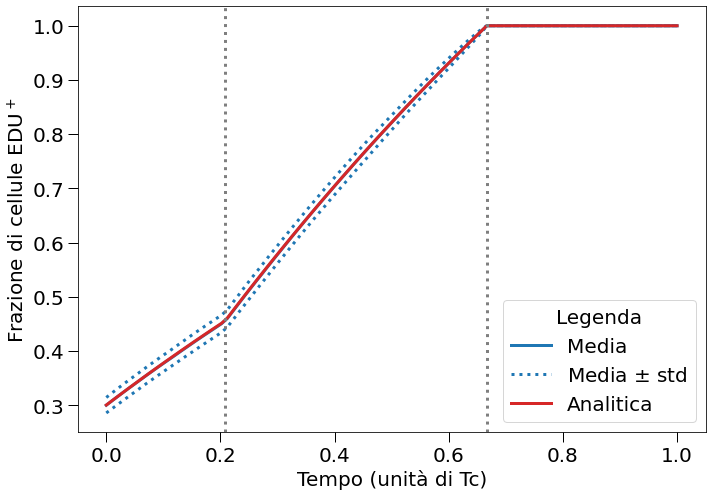

. . . . . . . . . . 


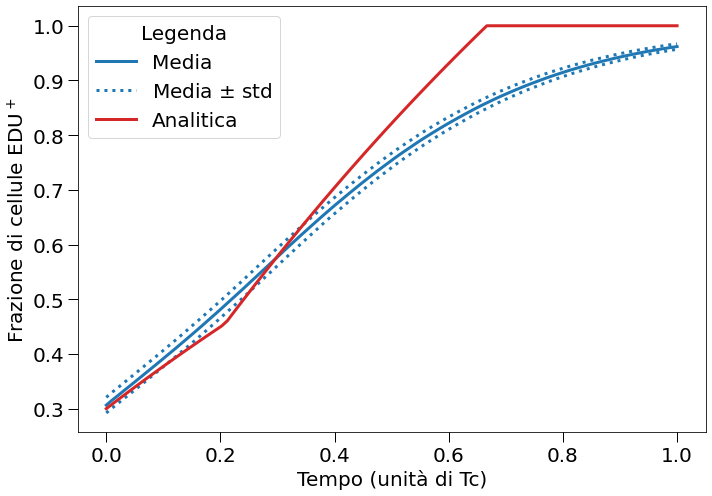

In [7]:
std_fractions = [0., 0.6]

for std_fraction in std_fractions:
    # Repeat simulation N times to get mean and std
    N_simulations = 1000
    # parameters for the simulation
    N_cells = 1000
    T_tot = 1.
    N_timesteps = 100
    #single runs results
    # num rows = N_timestep
    # num cols = N_simulation
    # results[i][j] = result at time i for simulation j 
    results = [ [] for _ in range(N_timesteps)]
    
    #All runs results
    mean = []
    std = []
    
    # Simulate
    for _ in range(N_simulations):
        # Progress bar
        progress = N_simulations/10
        if _%progress == 0:
            print(".", end=" ")
        if _ == N_simulations - 1 :
            print()
        # Single run
        exp = EDU_stochastic_experiment(T_tot = T_tot, N_cells = N_cells, std_fraction = std_fraction)
        exp.run_experiment_new_random(N_timesteps = N_timesteps)
        # save data
        for i in range(N_timesteps) :
            results[i].append(exp._positive_fraction[i])
            
    # process results
    for i in range(N_timesteps) :
        mean.append(np.mean(results[i]))
        std.append(np.std(results[i]))
    
    # Plot results
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(1, 1, 1)
    
    ## set ticks
    ax.tick_params(which='major', width=1.0, labelsize=20)
    ax.tick_params(which='major', length=10, labelsize=20)
    
    ax.set_ylabel(r"Frazione di cellule EDU${}^+$", fontsize=20)
    ax.set_xlabel("Tempo (unità di Tc)", fontsize=20)
    ax.yaxis.offsetText.set_fontsize(20)
    
    times = np.linspace(0., T_tot, num = N_timesteps)
    mean_plus_std = [mean[i] + std[i] for i in range(N_timesteps)]
    mean_minus_std = [mean[i] - std[i] for i in range(N_timesteps)]
    ax.plot(times, mean, color = "tab:blue",lw=3, label = "Media")
    ax.plot(times, mean_plus_std,lw=3, color = "tab:blue", ls=":", label =r"Media $\pm$ std")
    ax.plot(times, mean_minus_std,lw=3, color = "tab:blue", ls=":")

    #plot also analytic estimation
    f = []
    for t in exp._times:
        if t < exp._TG2M : # t < T_G2M
            f.append(math.pow(2., (exp._TG2M + exp._TS)/exp._Tc) 
                        - math.pow(2., (exp._TG2M - t)/exp._Tc)
                    )
        else: # t > T_G2M
            if t < (exp._Tc - exp._TS) : # T_G2M <= t < (T_c - T_S)
                f.append(1. - (math.pow(2., (exp._TG2M + exp._Tc - t)/exp._Tc)
                                - math.pow(2., (exp._TG2M + exp._TS)/exp._Tc)
                                )
                        )
            else: # t >= (T_c - T_S)
                f.append(1.)
        
    ax.plot(exp._times, f, label = "Analitica", color = "tab:red", lw=3)
    ax.legend(fontsize=20, title='Legenda',title_fontsize=20)

    plt.tight_layout()
        
    if (std_fraction == 0.):
        ax.axvline(x= (exp._TG1 + exp._TG2M), label=r"$T_{G_1}+T_{(G_2+M)}$", color = "tab:gray", ls = ":", lw = 3)
        ax.axvline(x= exp._TG2M, label=r"$T_{(G2+M)}$", color = "tab:gray", ls = ":", lw = 3)
        #plt.savefig("deterministic_EDU.pdf")

    plt.show()

## EDU simulations - stochastic model (exponential times)

In [8]:
class EDU_stochastic_experiment_Poisson :
    """ Cell times are exponentially distributed """
    
    def __init__(self, N_cells = 1000, T_tot = 1.3, 
                 Tc = 1., TG1 = 11./24, TS = 8./24, TG2M = 5./24):
        
        # Initial number of cells
        self._N_cells = N_cells
        self._initial_N_cells = N_cells
        
        # Total time of the experiment
        self._T_tot = T_tot
        
        # Mean Phases' times
        self._TG1 = TG1 # G1
        self._TS = TS # S
        self._TG2M = TG2M # G2 + M
        self._Tc = Tc # Total cell cycle time
        
        
        assert Tc == TG1 + TS + TG2M
        
        # The population is a list of cells
        self._population = []
        
        # generate initial population
        for _ in range(self._N_cells) :
            
            # Sample phases' times as exponentially distributed
            # around mean values 
            TG1 = np.random.exponential(scale = self._TG1)
            TS = np.random.exponential(scale = self._TS)
            TG2M = np.random.exponential(scale = self._TG2M)
                        
            #campute Tc
            Tc = TG1 + TS + TG2M
            
            # Sample age from ages' distribution given that Tc
            age = self.sample_age(Tc)
            
            # Add a cell with sampled parameters to population
            # that is unlabelled
            self._population.append(
                Cell(age = age, labelled = False,
                     TG1 = TG1, TS = TS, 
                     TG2M = TG2M, Tc = Tc)
            )
            
        # Results are couples (t, %EDU-positive)
        self._times = []
        self._positive_fraction = []
        
    def sample_age(self, Tc):
        # Sample random age from ages distribution
        # Accept-Reject method
        accepted = False
        while not accepted:
            # sample uniformly one age from 0 to Tc
            u = np.random.uniform(low = 0., high = Tc)
            # sample uniformly from min to max
            # values of the ages distribution
            v = np.random.uniform(low = 0., high = math.log(4)/Tc + 0.01)
            # accept or reject
            if v <= self.age_distribution(u, Tc):
                accepted = True
        # return accepted age
        return u;
    
    def age_distribution(self, a, Tc):
        # Age distribution of cells given the 
        # cell cycle lenght Tc
        return (2*math.log(2)/Tc)*math.exp(-math.log(2)*a/Tc)
    
    def run_experiment_new_random(self, N_timesteps = 100):
        """ Stochastic version in which times of new cells 
            are randomly sampled """
        
        # Times at which positive cells cout is performed
        self._times = np.linspace(0., self._T_tot, num = N_timesteps)
        delta_t = self._times[1]
        
        # For all measurement's times
        for t in self._times:
           
            new_born = 0  # New born cells counter
            new_ages = [] # ages of new cells
            new_labelled = [] # label-status of new cells
            
            # For all cells
            for cell in self._population:
                # add delta_t to cell age
                cell._age += delta_t
                # if cell is in the S phase
                if (cell._age >= cell._TG1 ) & (cell._age <= cell._TG1 + cell._TS) :
                    # mark the cell as labelled 
                    cell._labelled = True
                    
                # if the cell completed the cycle
                if cell._age > cell._Tc:
                    # the cell divide and two new cell are made
                    # total number of cell increases by onetimes
                    self._N_cells += 1
                    
                    # daughters will be labelled if the progenitor were labelled
                    labelled = cell._labelled 
                    
                    # the age of the new cells is the difference 
                    # between (age + t) and Tc
                    age = cell._age - cell._Tc
                    
                    # Two new cells in population are the old cell
                    # with age set to the new one and another new cell
                    # that we need to add
                    
                    #Set new parameters for the old cell in population
                    
                    # Set old cell's age to the new cell age
                    cell._age = age 
                    
                    # EDU label is the same as before 
                    
                    # sample new times for the phases
                    TG1 = np.random.exponential(scale = self._TG1)
                    TS = np.random.exponential(scale = self._TS)
                    TG2M = np.random.exponential(scale = self._TG2M)
                    
                    Tc = TG1 + TS + TG2M
                    
                    # Set old cell's times to the new ones
                    cell._TG1 = TG1
                    cell._TS = TS
                    cell._TG2M = TG2M
                    cell._Tc = Tc
                    
                    
                    # we need to add a cell to population list
                    # but we can't do that during this iteration 
                    # (on population list).
                    # So we have to save total number of new born cells 
                    # to add later and their age and label-status
                    new_born += 1
                    new_ages.append(age)
                    new_labelled.append(labelled)
            
            # We add new cells to the population list
            #for every new cell
            for i in range(new_born):
                # sample times 
                TG1 = np.random.exponential(scale = self._TG1)
                TS = np.random.exponential(scale = self._TS)
                TG2M = np.random.exponential(scale = self._TG2M)
                    
                Tc = TG1 + TS + TG2M
                
                # we add a cell with saved age and label-status
                # we use also sampled times
                self._population.append(
                    Cell(age = new_ages[i], labelled = new_labelled[i], 
                         TG1 = TG1, TS = TS, 
                         TG2M = TG2M, Tc = Tc)
                )
            
            #We then perform EDU-positive cell count 
            EDU_positive = 0
            
            for cell in self._population :
                if cell._labelled :
                    EDU_positive += 1
            times
            # calculate EDU-positive fraction of cells
            positive_fraction = float(EDU_positive)/float(self._N_cells)
            # save result
            self._positive_fraction.append(positive_fraction)
            
    def plot_EDU(self):
        plt.plot(self._times, self._positive_fraction, label= "simulation")
        plt.title("Stochastic EDU experiment - Poisson process\n"+str(self._initial_N_cells)+" initial cells")
        plt.ylabel(r"Fraction of EDU${}^+$ cells")
        plt.xlabel("Time (units of Tc)")
        # plot analytic estimation form explicit cell cicle
        # Eq. 8 from "EDU_labelling_dynamics"
        f = []
        for t in self._times:
            if t < self._TG2M : # t < T_G2M
                f.append(math.pow(2., (self._TG2M + self._TS)/self._Tc) 
                         - math.pow(2., (self._TG2M - t)/self._Tc)
                        )
            else: # t > T_G2M
                if t < (self._Tc - self._TS) : # T_G2M <= t < (T_c - T_S)
                    f.append(1. - (math.pow(2., (self._TG2M + self._Tc - t)/self._Tc)
                                  - math.pow(2., (self._TG2M + self._TS)/self._Tc)
                                  )
                            )
                else: # t >= (T_c - T_S)
                    f.append(1.)
        
        plt.plot(self._times, f, label = "analytic")
        plt.legend()

. . . . . . . . . . 


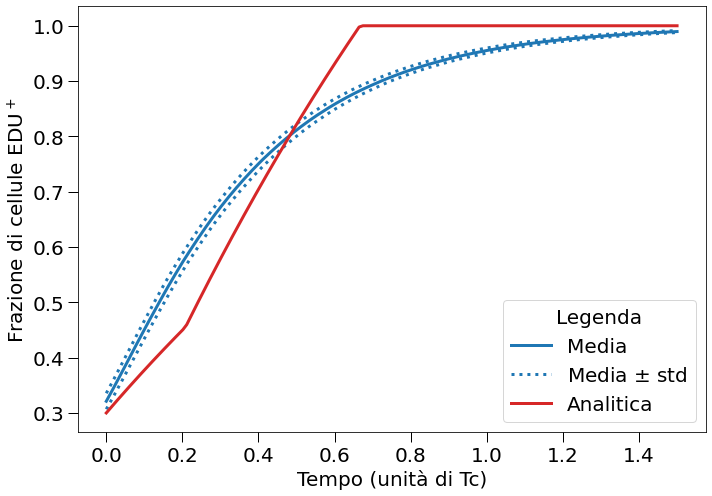

In [9]:
# Repeat simulation N times to get mean and std
N_simulations = 1000

# parameters for the simulation
N_cells = 1000
T_tot = 1.5
N_timesteps = 150

#single runs results
# num rows = N_timestep
# num cols = N_simulation
# results[i][j] = result at time i for simulation j 
results = [ [] for _ in range(N_timesteps)]

#All runs results
mean = []
std = []

# Simulate
for _ in range(N_simulations):
    # Progress bar
    progress = N_simulations/10
    if _%progress == 0:
        print(".", end=" ")
    if _ == N_simulations - 1 :
        print()
    # Single run
    exp = EDU_stochastic_experiment_Poisson(N_cells = N_cells, T_tot = T_tot)
    exp.run_experiment_new_random(N_timesteps = N_timesteps)
    
    # save data
    for i in range(N_timesteps) :
        results[i].append(exp._positive_fraction[i])

# process results times
for i in range(N_timesteps) :
    mean.append(np.mean(results[i]))
    std.append(np.std(results[i]))

# Plot results
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1)
    
## set ticks
ax.tick_params(which='major', width=1.0, labelsize=20)
ax.tick_params(which='major', length=10, labelsize=20)
    
ax.set_ylabel(r"Frazione di cellule EDU${}^+$", fontsize=20)
ax.set_xlabel("Tempo (unità di Tc)", fontsize=20)
ax.yaxis.offsetText.set_fontsize(20)
    
times = np.linspace(0., T_tot, num = N_timesteps)
mean_plus_std = [mean[i] + std[i] for i in range(N_timesteps)]
mean_minus_std = [mean[i] - std[i] for i in range(N_timesteps)]

ax.plot(times, mean, color = "tab:blue",lw=3, label = "Media")
ax.plot(times, mean_plus_std,lw=3, color = "tab:blue", ls=":", label =r"Media $\pm$ std")
ax.plot(times, mean_minus_std,lw=3, color = "tab:blue", ls=":")

# plot analytic estimation form explicit cell cicle
# Eq. 8 from "EDU_labelling_dynamics"
f = []
for t in exp._times:
    if t < exp._TG2M : # t < T_G2M
        f.append(math.pow(2., (exp._TG2M + exp._TS)/exp._Tc) 
                - math.pow(2., (exp._TG2M - t)/exp._Tc)
                )
    else: # t > T_G2M
        if t < (exp._Tc - exp._TS) : # T_G2M <= t < (T_c - T_S)
            f.append(1. - (math.pow(2., (exp._TG2M + exp._Tc - t)/exp._Tc)
                           - math.pow(2., (exp._TG2M + exp._TS)/exp._Tc)
                          )
                    )
        else: # t >= (T_c - T_S)
            f.append(1.)
        
ax.plot(exp._times, f, label = "Analitica", color = "tab:red", lw=3)
ax.legend(fontsize=20, title='Legenda',title_fontsize=20)

plt.tight_layout()
#plt.savefig("Poisson_EDU_experiment.pdf")

## EDU incorporation variability across experimental replicas varying cell number

Figures A6 and A7 from section A.3

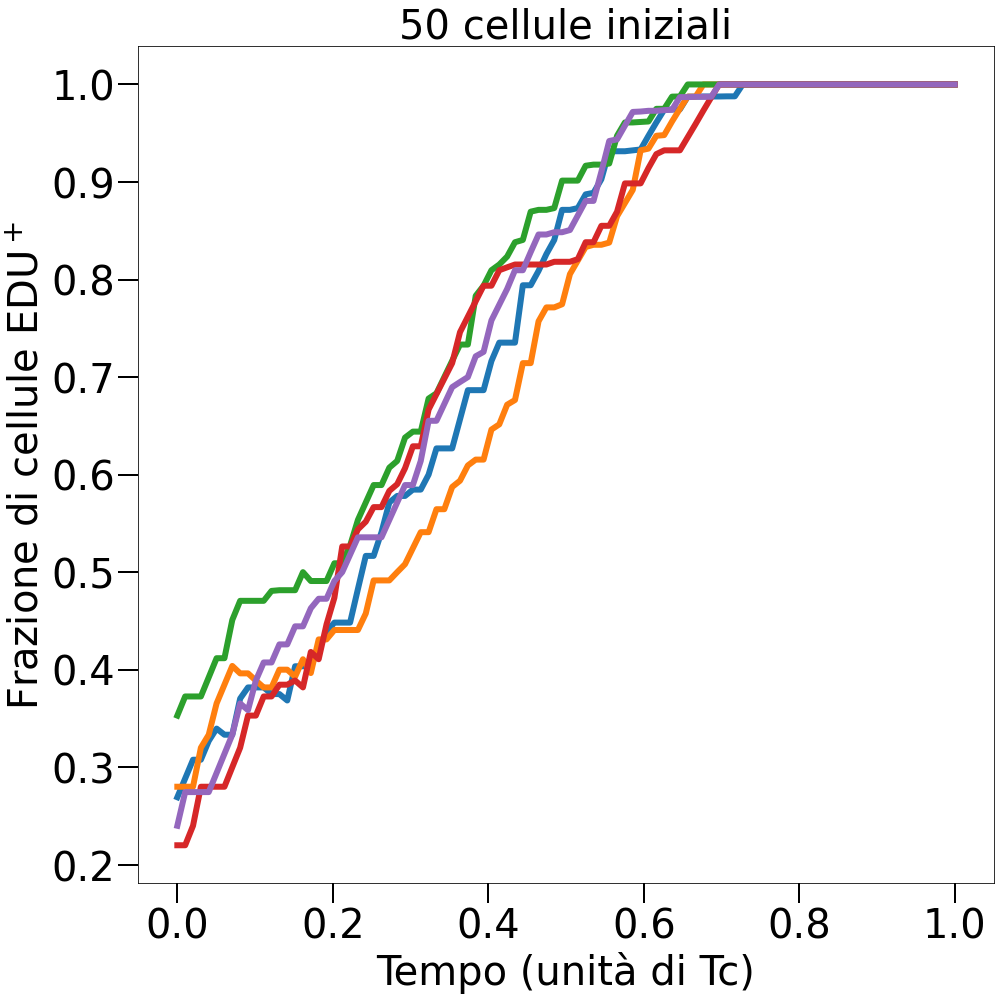

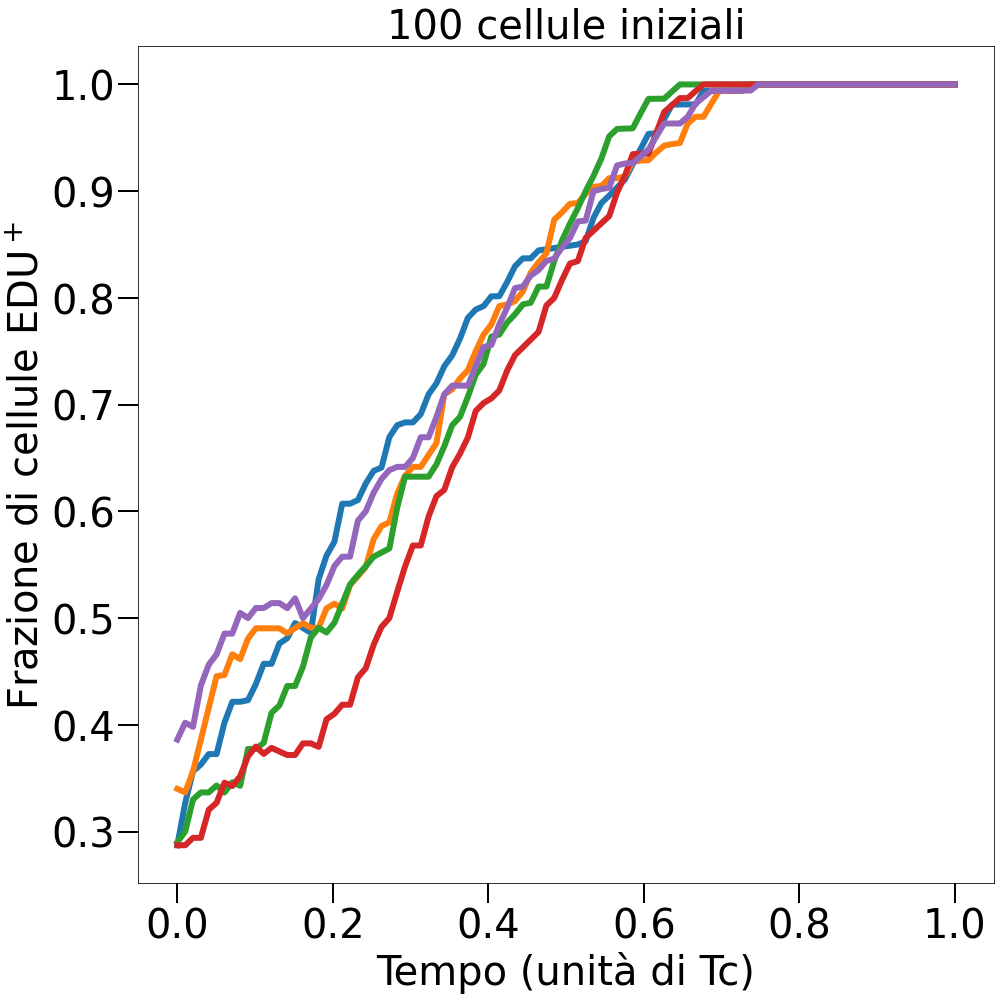

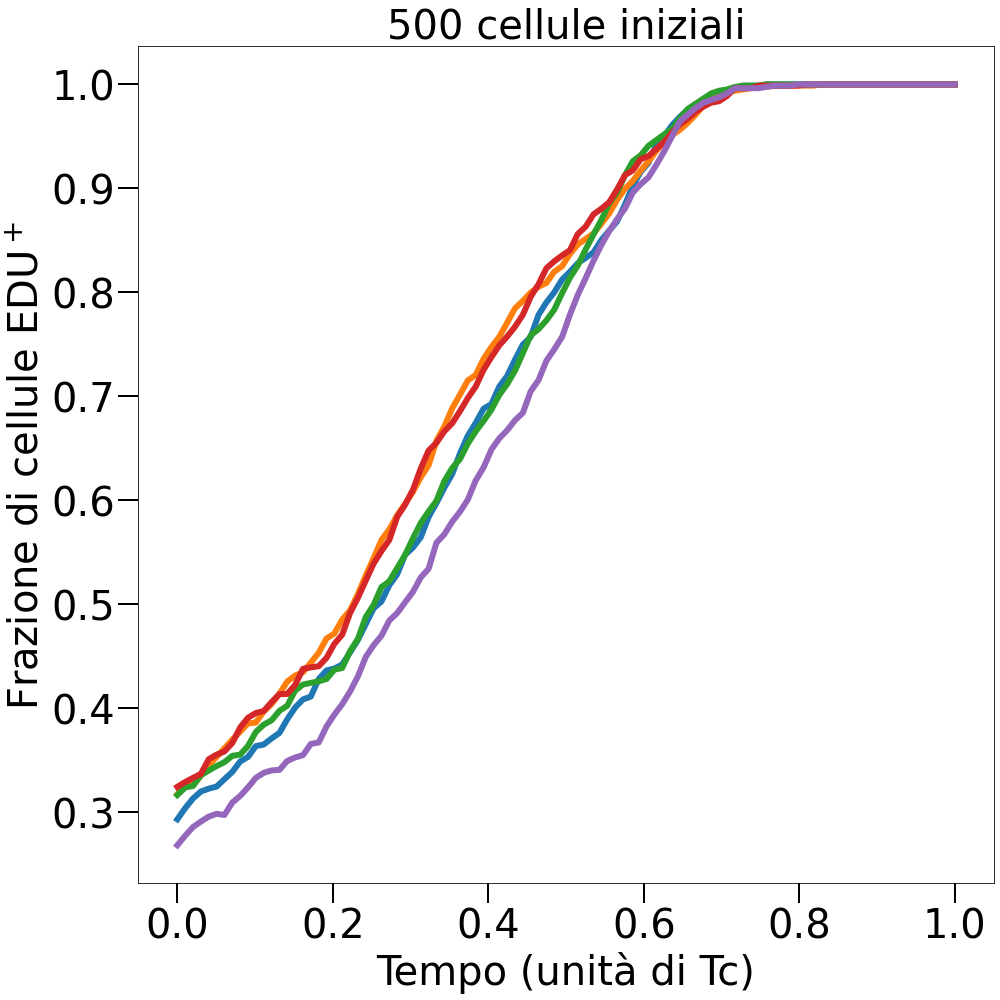

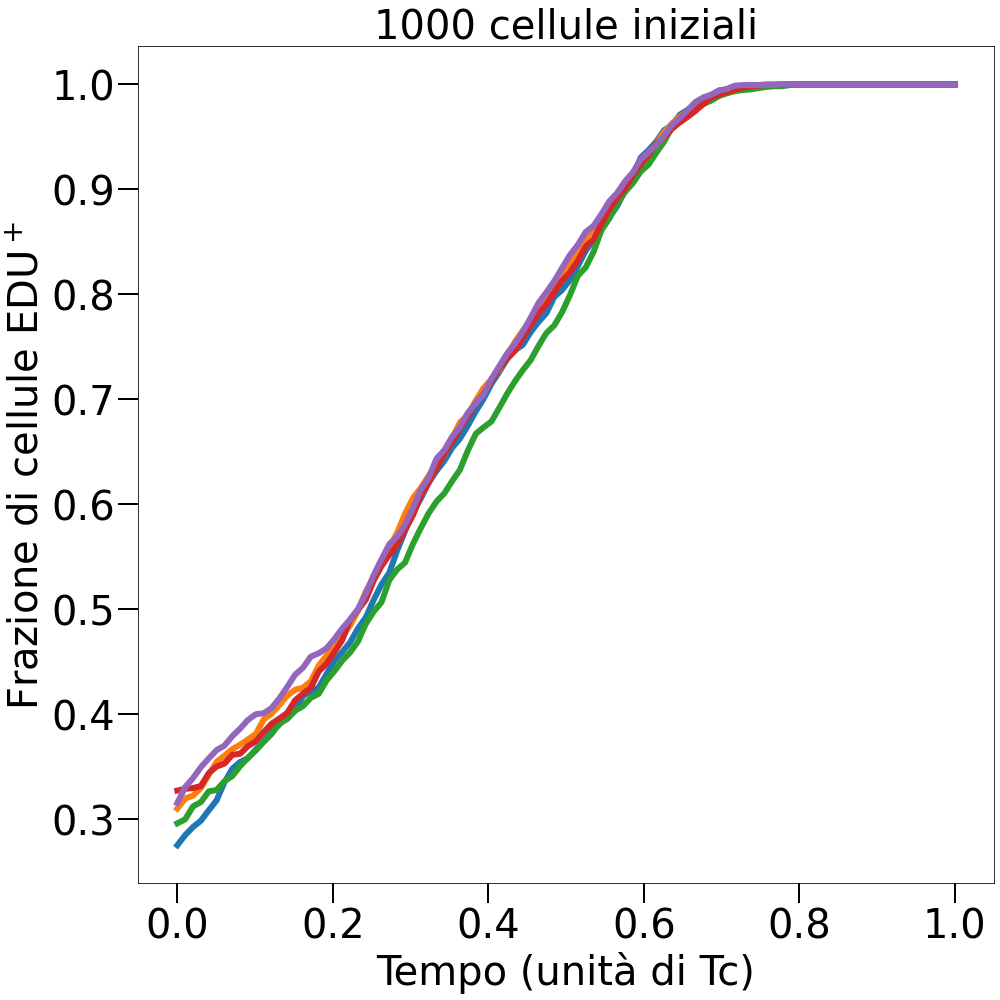

In [10]:
N_tots = [50, 100, 500, 1000]
N_sim = 5

for N_tot in N_tots:
    
    # Plot results
    fig = plt.figure(figsize=(14,14))
    ax = fig.add_subplot(1, 1, 1)
    ## set ticks
    ax.set_title(str(N_tot) +" cellule iniziali", fontsize=40)
    ax.tick_params(which='major', width=2.0, labelsize=40)
    ax.tick_params(which='major', length=20, labelsize=40)
    
    ax.set_ylabel(r"Frazione di cellule EDU${}^+$", fontsize=40)
    ax.set_xlabel("Tempo (unità di Tc)", fontsize=40)
    ax.yaxis.offsetText.set_fontsize(40)
    
    for _ in range(N_sim):
        exp = EDU_stochastic_experiment(N_cells = N_tot, T_tot = 1.)
        exp.run_experiment_new_random(N_timesteps = 100)
        plt.plot(exp._times, exp._positive_fraction, lw = 6)
    
    plt.tight_layout()
    
    #plt.savefig("EDU_variability_gauss_" + str(N_tot) + ".pdf")
    plt.show()

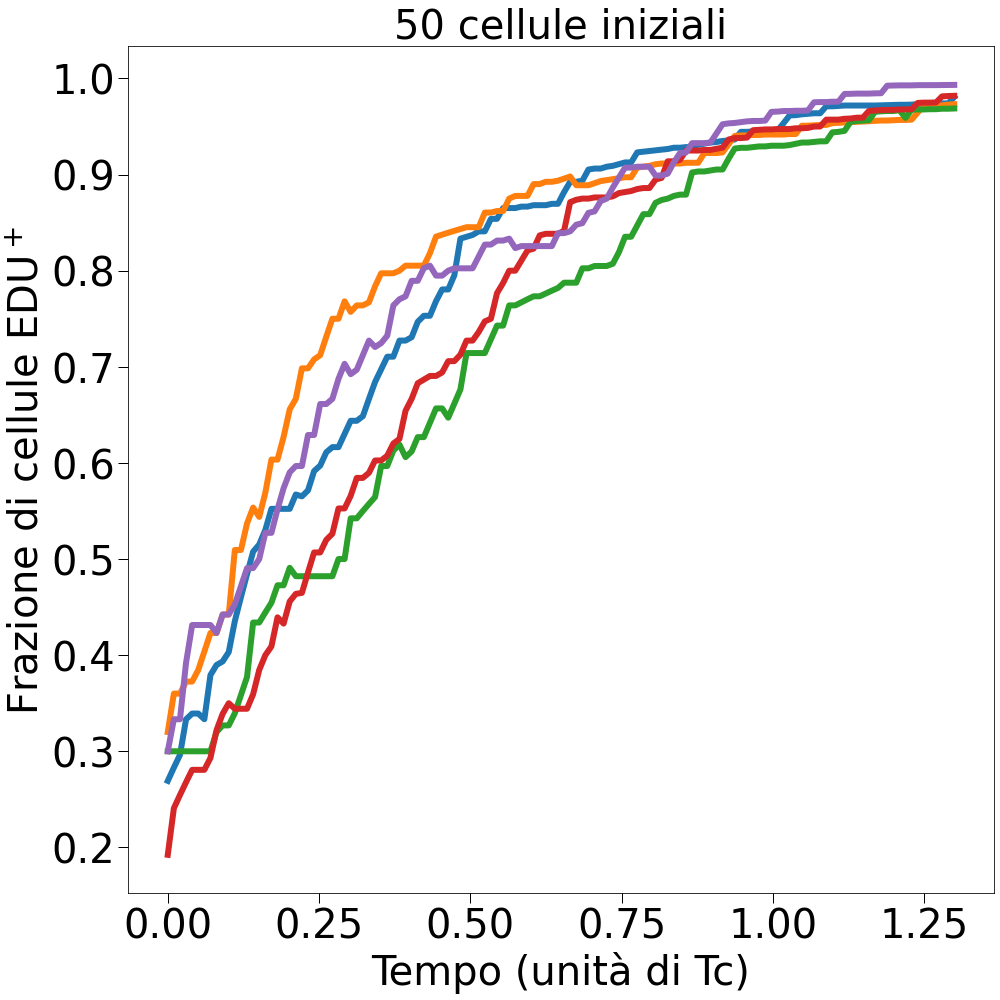

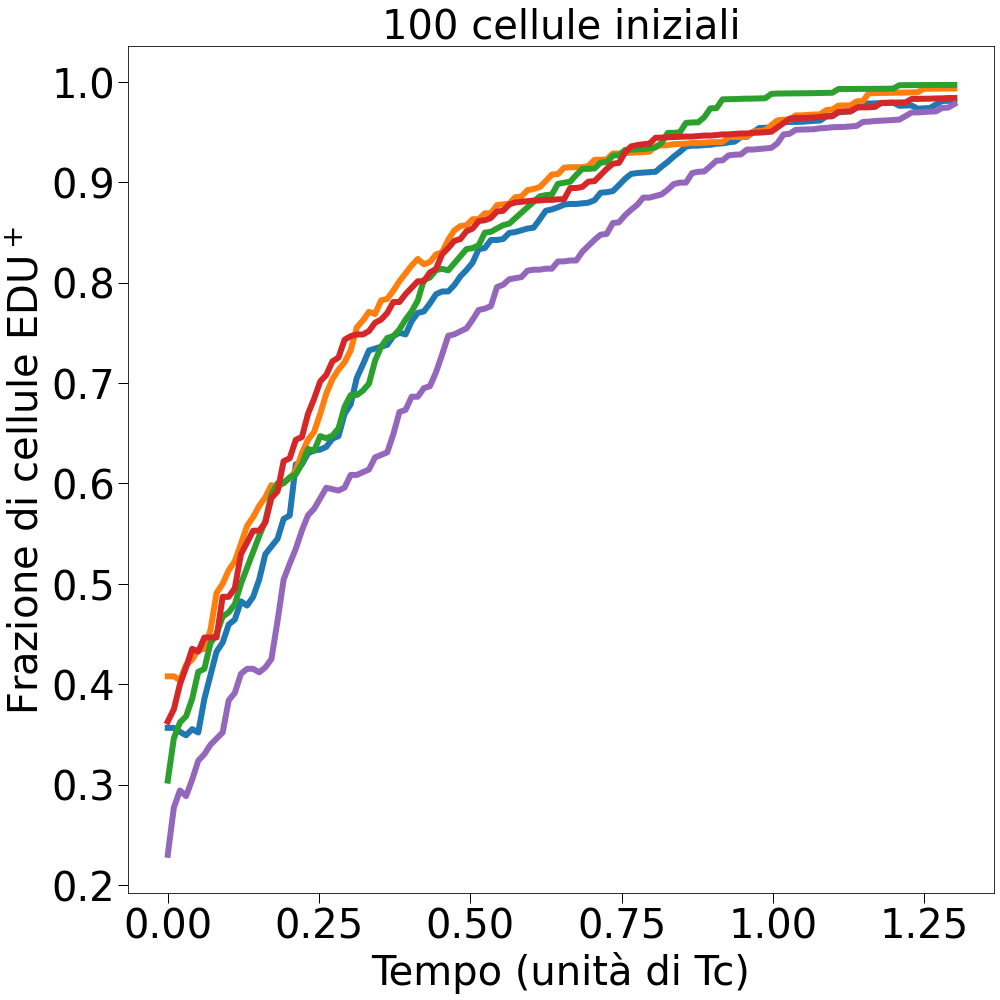

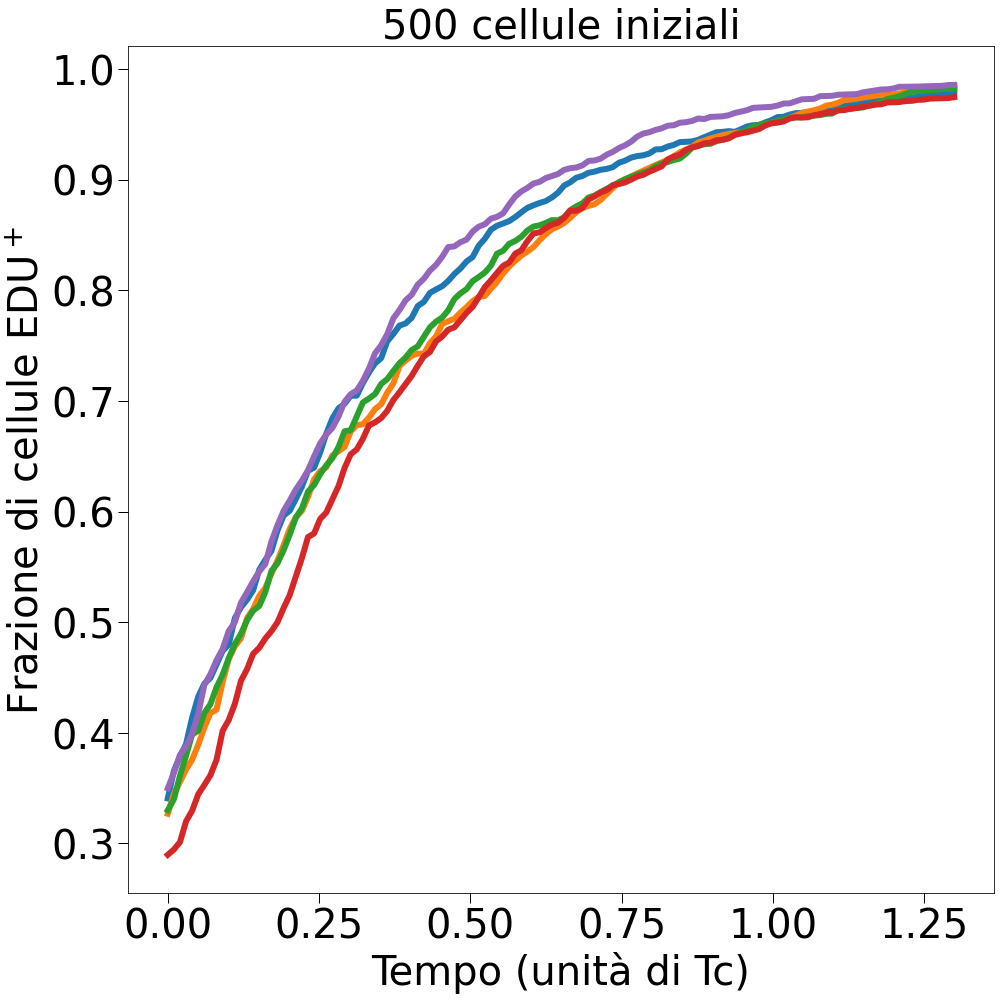

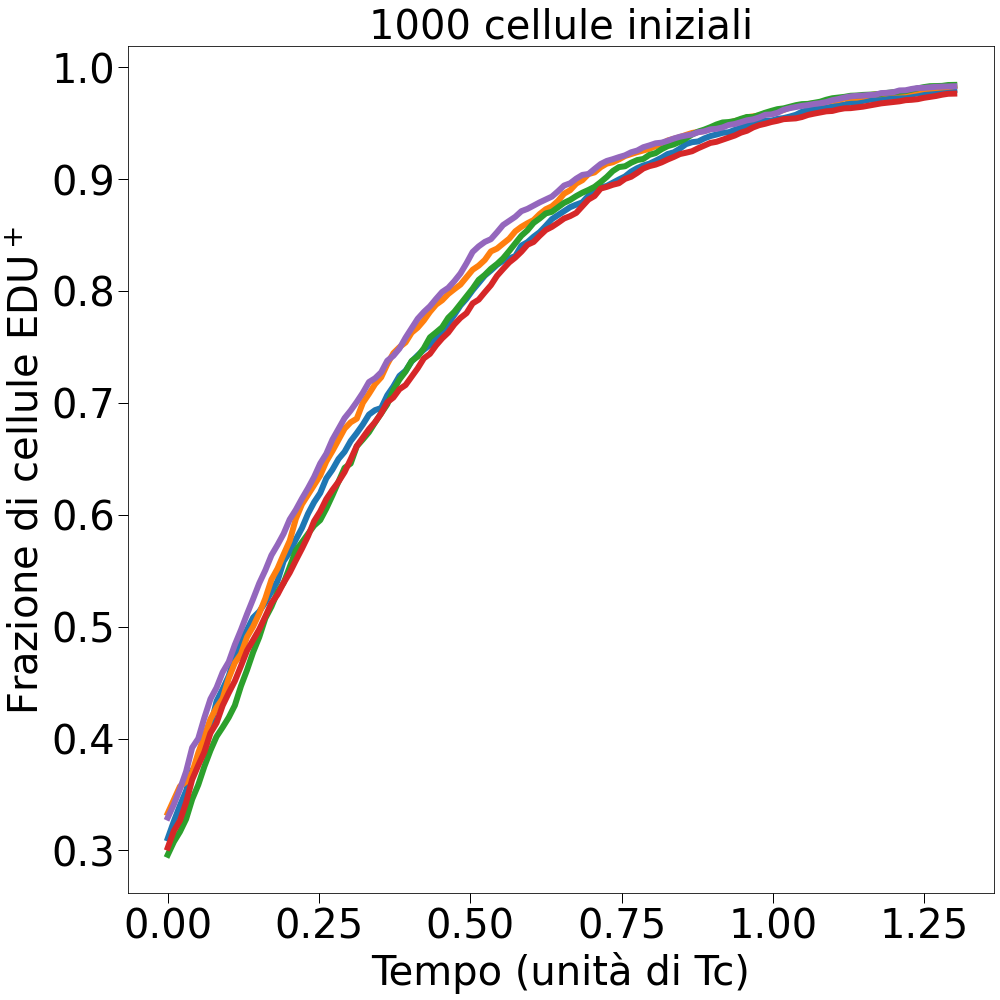

In [11]:
#Caso stocastico Poisson
#grafici al variare del numero di cellule 

N_tots = [50, 100, 500, 1000]
N_sim = 5


for N_tot in N_tots:
    # Plot results
    fig = plt.figure(figsize=(14,14))
    ax = fig.add_subplot(1, 1, 1)
    ## set ticks
    ax.set_title(str(N_tot) +" cellule iniziali", fontsize=40)
    ax.tick_params(which='major', width=1.0, labelsize=40)
    ax.tick_params(which='major', length=10, labelsize=40)
    
    ax.set_ylabel(r"Frazione di cellule EDU${}^+$", fontsize=40)
    ax.set_xlabel("Tempo (unità di Tc)", fontsize=40)
    ax.yaxis.offsetText.set_fontsize(40)
    for _ in range(N_sim):
        exp = EDU_stochastic_experiment_Poisson(N_cells = N_tot)
        exp.run_experiment_new_random(N_timesteps = 130)
        plt.plot(exp._times, exp._positive_fraction, lw = 6)
        
    plt.tight_layout()
    #plt.savefig("Poisson_EDU_variability_" + str(N_tot) + ".svg")
    plt.show()